# Plot data

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import models

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch

In [3]:
def plot_time_series(path):
    wav = np.load(path)
    plt.figure(figsize=(10,3))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)
    plt.xticks(np.arange(0,len(wav)+1, 1000), [x/1000 for x in np.arange(0,len(wav)+1, 1000)])
    plt.xlabel("Time (s)", fontsize=25)
    plt.plot(wav)

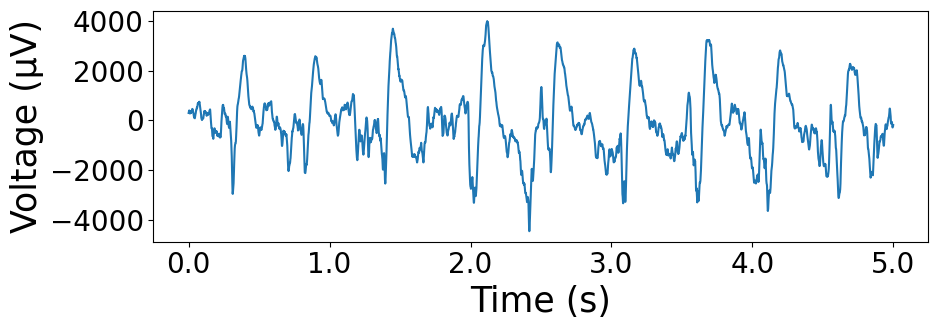

In [4]:
data_path = "/mnt/AI_Magic/projects/iEEG_data/ucla/EEG_Data_90min/brainBERT_data/Pt1_AR_POL G23_21.npy"
plot_time_series(data_path)

In [5]:
def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)
    
    print(f"Shape of Zxx: {Zxx.shape}, shape of f: {f.shape}, shape of t: {t.shape}")
   
    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]
    
    print(f"Shape of Zxx: {Zxx.shape}, shape of f: {f.shape}, shape of t: {t.shape}")

    Zxx = np.abs(Zxx)
    
    print(f"Shape of Zxx: {Zxx.shape}, shape of f: {f.shape}, shape of t: {t.shape}")
    
    clip = 5 #To handle boundary effects
    if normalizing=="zscore":
        Zxx = Zxx[:,clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing=="baselined":
        Zxx = baseline(Zxx[:,clip:-clip])
        t = t[clip:-clip]
    elif normalizing=="db":
        Zxx = np.log2(Zxx[:,clip:-clip])
        t = t[clip:-clip]
        
    print(f"Shape of Zxx: {Zxx.shape}, shape of f: {f.shape}, shape of t: {t.shape}")

    if np.isnan(Zxx).any():
        import pdb; pdb.set_trace()

    return f, t, Zxx

def plot_stft(path):
    wav = np.load(path)
    f,t,linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
    plt.figure(figsize=(15,3))
    f[-1]=200
    g1 = plt.pcolormesh(t,f,linear, shading="gouraud", vmin=-3, vmax=5)

    cbar = plt.colorbar(g1)
    tick_font_size = 15
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
    plt.xticks(fontsize=20)
    plt.ylabel("")
    plt.yticks(fontsize=20)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Frequency (Hz)", fontsize=20)

Shape of Zxx: (201, 101), shape of f: (201,), shape of t: (101,)
Shape of Zxx: (40, 101), shape of f: (40,), shape of t: (101,)
Shape of Zxx: (40, 101), shape of f: (40,), shape of t: (101,)
Shape of Zxx: (40, 91), shape of f: (40,), shape of t: (91,)


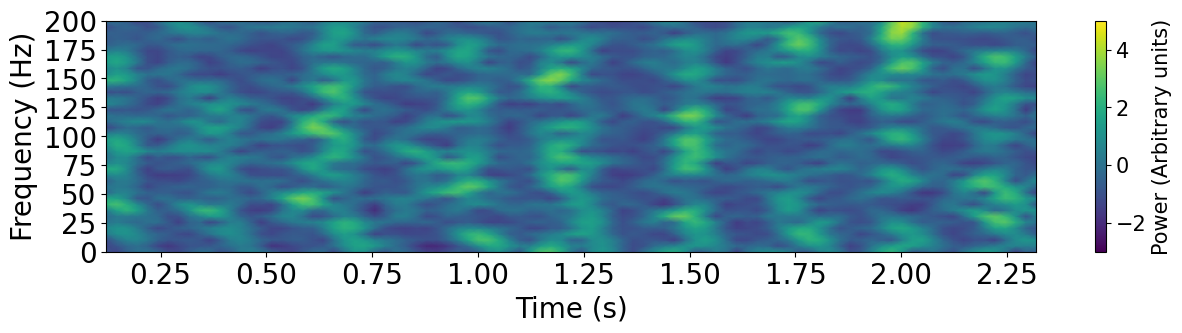

In [6]:
plot_stft(data_path)

# Load model

In [7]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream, upstream_cfg

def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)

In [9]:
from omegaconf import OmegaConf

device = "cuda:1"
ckpt_path = "../pretrained_weights/stft_large_pretrained.pth"
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
model, upstream_cfg = build_model(cfg)
model.to(device)
init_state = torch.load(ckpt_path)
load_model_weights(model, init_state['model'], False)

In [10]:
upstream_cfg

{'name': 'masked_tf_model', 'hidden_dim': 768, 'layer_dim_feedforward': 3072, 'layer_activation': 'gelu', 'nhead': 12, 'encoder_num_layers': 6, 'input_dim': 40}

# Get output

In [11]:
wav = np.load(data_path)
f,t,linear = get_stft(wav, 1000, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1,2).to(device)
mask = torch.zeros((inputs.shape[:2])).bool().to(device)
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=False)

Shape of Zxx: (201, 101), shape of f: (201,), shape of t: (101,)
Shape of Zxx: (40, 101), shape of f: (40,), shape of t: (101,)
Shape of Zxx: (40, 101), shape of f: (40,), shape of t: (101,)
Shape of Zxx: (40, 91), shape of f: (40,), shape of t: (91,)


In [23]:
wav.shape

(5000,)

In [15]:
print(out[0].shape, out[1].shape)

torch.Size([1, 91, 40]) torch.Size([1, 91, 768])


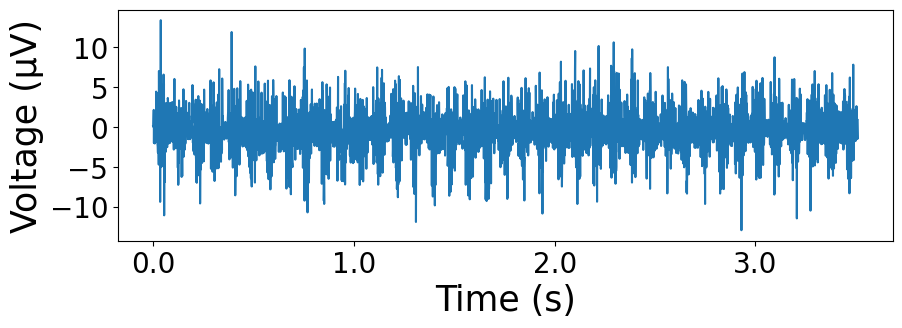

In [30]:
from scipy import signal

spec_recon = out[0].cpu().numpy().squeeze()
_, xrec = signal.istft(spec_recon, 1000)

plt.figure(figsize=(10,3))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)
plt.xticks(np.arange(0,len(wav)+1, 1000), [x/1000 for x in np.arange(0,len(wav)+1, 1000)])
plt.xlabel("Time (s)", fontsize=25)
plt.plot(xrec)

In [24]:
import mne

raw = mne.io.read_raw_edf("/mnt/AI_Magic/projects/iEEG_data/ucla/New iEEG data/Pt1_AR/AR2_A_ave.edf", preload=True)

Extracting EDF parameters from /mnt/AI_Magic/projects/iEEG_data/ucla/New iEEG data/Pt1_AR/AR2_A_ave.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11097999  =      0.000 ...  5548.999 secs...


In [25]:
laplacian = mne.preprocessing.compute_current_source_density(raw, lambda2=1e-5)


RuntimeError: Cannot fit headshape without digitization , info["dig"] is None

In [ ]:
laplacian

In [20]:
import pandas as pd

labels = pd.read_csv("/mnt/AI_Magic/projects/iEEG_data/ucla/New iEEG data/Pt1_AR/label.csv")
labels

,patient_name,channel_name,start,end,detector_type,artifact,spike,duration,SOZ,Resection,bad,label,index
0,Pt1_AR,POL G6,3346131.0,3346151.0,mni,1.0,1.0,20.0,0,1,0,1,0
1,Pt1_AR,POL G6,4233752.0,4233768.0,mni,1.0,1.0,16.0,0,1,0,1,1
2,Pt1_AR,POL G6,4297073.0,4297089.0,mni,1.0,1.0,16.0,0,1,0,1,2
3,Pt1_AR,POL G6,4347712.0,4347724.0,mni,1.0,1.0,12.0,0,1,0,1,3
4,Pt1_AR,POL G6,4487785.0,4487802.0,mni,1.0,1.0,17.0,0,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,Pt1_AR,POL PD4,1540434.0,1540464.0,ste,1.0,0.0,30.0,0,0,0,0,678
679,Pt1_AR,POL PD4,1540499.0,1540534.0,ste,1.0,0.0,35.0,0,0,0,0,679
680,Pt1_AR,POL PD4,1621149.0,1621175.0,ste,0.0,-1.0,26.0,0,0,0,0,680
681,Pt1_AR,POL PD4,2042281.0,2042307.0,ste,0.0,-1.0,26.0,0,0,0,0,681


(array([642.,   3.,   3.,   2.,   6.,   6.,   9.,   5.,   3.,   4.]),
 array([0.011 , 0.1073, 0.2036, 0.2999, 0.3962, 0.4925, 0.5888, 0.6851,
        0.7814, 0.8777, 0.974 ]),
 <BarContainer object of 10 artists>)

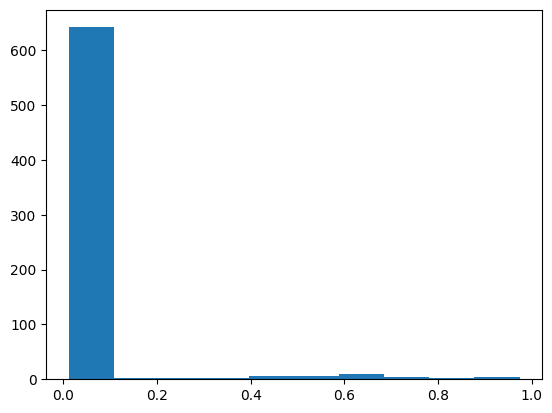

In [23]:
plt.hist((labels["end"].values - labels["start"].values) / 1000)

In [18]:
inputs.shape, out.shape

NameError: name 'inputs' is not defined